In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# from model_fitting import least_sq_fit

In [23]:
def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

def gaussian(x, a, b, c):
    return a * np.exp(-(x-b)**2/(2*c**2))

def sinusoid(x, a, b, c):
    return a*np.sin(b*x + c)

In [62]:
xdata = np.arange(-25, 25, 0.1)
yquad = quadratic(xdata, -2, -24, 0)
ygaus = gaussian(xdata, 200, 1, -3)
ysine = sinusoid(xdata, 4, 3, 2)

In [63]:
quad_params, qhist = least_sq_fit(quadratic, xdata, yquad, init_params = np.array([9, 1, 0]), show_history=True, step_size=.9)

print(quad_params, qhist)

sine_params, ghist = least_sq_fit(sinusoid, xdata, ygaus, init_params = np.array([1, 1, 1]), show_history=True, step_size=.9)

print(sine_params, ghist)

[-2.00002578e+00 -2.40000016e+01  9.69590125e-03] [4.78319948e+09 1.19836016e+09 3.36655141e+08 ... 2.08930883e-02
 2.08925781e-02 2.08920217e-02]
[28.64066292  0.41742476 13.06784059] [2126890.35134783 2104971.24948134 2014303.73046936 ... 2014303.73046936
 2014303.73046936 2014303.73046936]


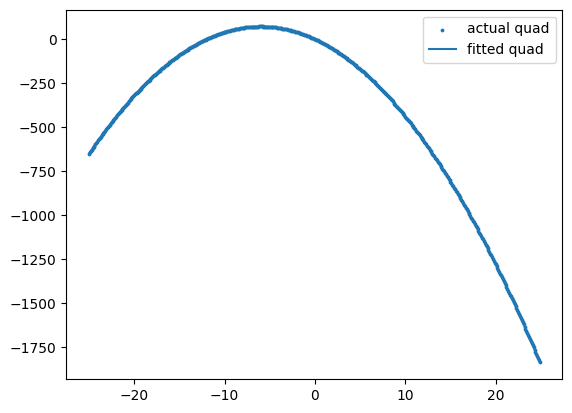

In [64]:

plt.scatter(xdata, yquad, s = 3, label = 'actual quad')
plt.plot(xdata, quadratic(xdata, *quad_params), label = 'fitted quad')
plt.legend()


In [66]:

def grad_descent(model, xdata, ydata, params, step_scale=1e-2):
    grad = np.zeros_like(params)

    for i in range(len(params)):
        # Larger, more robust central difference step
        h = max(step_scale * (abs(params[i]) + 1.0), 1e-4)
        dparams = np.zeros_like(params)
        dparams[i] = h

        y_plus  = model(xdata, *(params + dparams))
        y_minus = model(xdata, *(params - dparams))

        sq_err_plus  = np.sum((ydata - y_plus)**2)
        sq_err_minus = np.sum((ydata - y_minus)**2)

        grad[i] = (sq_err_plus - sq_err_minus) / (2 * h)

    return grad


def least_sq_fit(model, xdata, ydata, init_params,
                 show_history=False, max_iterations=5000,
                 tolerance=1e-5, step_scale=1e-2,
                 learn_rate=5e-2, backtrack=0.7, verbose=False):

    params = init_params.copy().astype(float)
    history = []

    for it in range(max_iterations):
        y_pred = model(xdata, *params)
        sse = np.sum((ydata - y_pred)**2)
        history.append(sse)

        grad = grad_descent(model, xdata, ydata, params, step_scale)
        grad_norm = np.linalg.norm(grad)

        if verbose and it % 200 == 0:
            print(f"Iter {it}: SSE={sse:.5e}, grad_norm={grad_norm:.3e}, params={params}")

        # Backtracking line search
        lr = learn_rate
        while True:
            new_params = params - lr * grad
            new_sse = np.sum((ydata - model(xdata, *new_params))**2)
            if new_sse < sse:
                params = new_params
                break
            lr *= backtrack
            if lr < 1e-10:
                break

        if grad_norm < tolerance:
            print(f"Converged at iteration {it}")
            break

    if show_history:
        return params, np.array(history)
    else:
        return params

Iter 0: SSE=5.05426e-01, grad_norm=2.065e+01, params=[0.01 0.3  1.   0.95]
Iter 200: SSE=2.44991e-03, grad_norm=7.982e-03, params=[0.01237128 0.29757015 0.99810385 1.0007098 ]
Iter 400: SSE=2.44007e-03, grad_norm=9.883e-03, params=[0.01239498 0.29503691 0.99637051 1.00070542]
Iter 600: SSE=2.43022e-03, grad_norm=1.134e-02, params=[0.0124184  0.29251137 0.99462589 1.00070215]
Iter 800: SSE=2.42036e-03, grad_norm=1.195e-02, params=[0.01244131 0.28999357 0.99287002 1.00070085]
Iter 1000: SSE=2.41046e-03, grad_norm=1.153e-02, params=[0.0124636  0.28748357 0.99110293 1.00070192]
Iter 1200: SSE=2.40055e-03, grad_norm=1.020e-02, params=[0.01248534 0.28498141 0.98932466 1.00070512]
Iter 1400: SSE=2.39062e-03, grad_norm=8.329e-03, params=[0.01250677 0.28248714 0.98753524 1.00070963]
Iter 1600: SSE=2.38084e-03, grad_norm=1.310e-02, params=[0.01253264 0.27999691 0.98573192 1.00069828]
Iter 1800: SSE=2.37085e-03, grad_norm=8.897e-03, params=[0.01255268 0.27751857 0.98392027 1.00070814]
Iter 2000: 

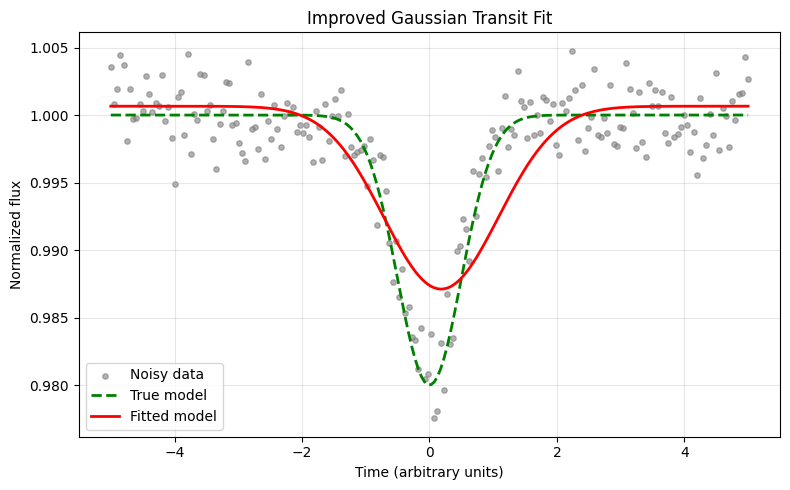

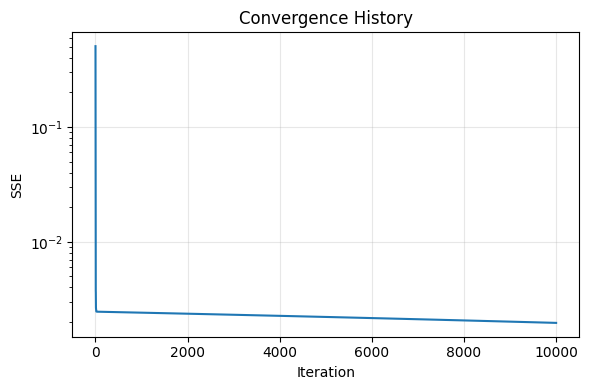

In [74]:

def gaussian_dip(x, depth, center, width, baseline):
    return baseline - depth * np.exp(-0.5 * ((x - center) / width)**2)


if __name__ == "__main__":
    np.random.seed(0)
    x = np.linspace(-5, 5, 200)
    true_params = np.array([0.02, 0.0, 0.5, 1.0])
    y_true = gaussian_dip(x, *true_params)
    y_noisy = y_true + np.random.normal(0, 0.002, len(x))

    init_params = np.array([0.01, 0.3, 1.0, 0.95])
    params, history = least_sq_fit(
        gaussian_dip, x, y_noisy, init_params,
        show_history=True, learn_rate=0.005,
        step_scale=1e-3, verbose=True, max_iterations=10000
    )

    print("\nTrue parameters:", true_params)
    print("Fitted parameters:", np.round(params, 5))

    plt.figure(figsize=(8, 5))
    plt.scatter(x, y_noisy, s=15, color="gray", alpha=0.6, label="Noisy data")
    plt.plot(x, y_true, "g--", label="True model", linewidth=2)
    plt.plot(x, gaussian_dip(x, *params), "r-", label="Fitted model", linewidth=2)
    plt.xlabel("Time (arbitrary units)")
    plt.ylabel("Normalized flux")
    plt.title("Improved Gaussian Transit Fit")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.semilogy(history)
    plt.xlabel("Iteration")
    plt.ylabel("SSE")
    plt.title("Convergence History")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

True parameters:   [0.02 0.   0.5  1.  ]
Fitted parameters: [ 0.0192  -0.00866  0.47388  0.99992]
Optimization success: True
Final SSE: 0.0008044551517886866


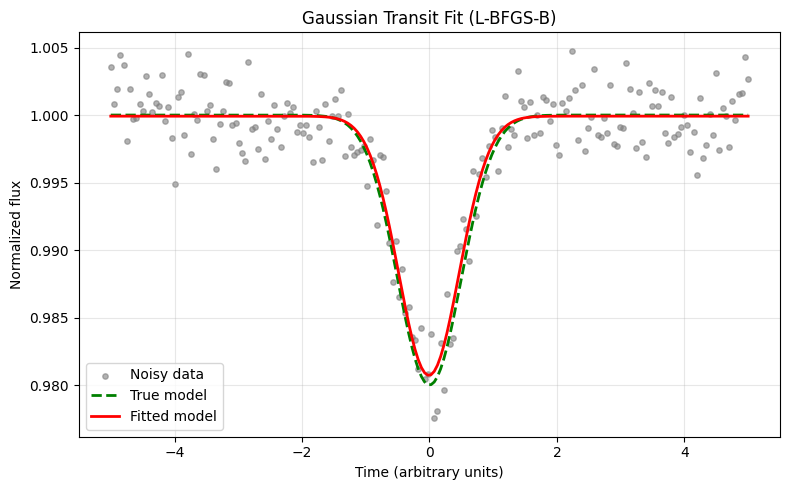

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Model function ---
def gaussian_dip(x, depth, center, width, baseline):
    return baseline - depth * np.exp(-0.5 * ((x - center) / width)**2)

# --- Sum of squared errors ---
def sse(params, x, y):
    depth, center, width, baseline = params
    y_pred = gaussian_dip(x, depth, center, width, baseline)
    return np.sum((y - y_pred)**2)

# --- Generate synthetic data (like an exoplanet transit) ---
np.random.seed(0)
x = np.linspace(-5, 5, 200)
true_params = [0.02, 0.0, 0.5, 1.0]
y_true = gaussian_dip(x, *true_params)
y_noisy = y_true + np.random.normal(0, 0.002, len(x))

# --- Initial guess ---
init_params = [0.01, 0.3, 1.0, 0.95]

# --- Fit using L-BFGS-B optimizer ---
result = minimize(sse, init_params, args=(x, y_noisy), method='L-BFGS-B',
                  bounds=[(0, None), (-2, 2), (0.1, 2), (0.5, 1.5)])

fitted_params = result.x

print("True parameters:  ", np.round(true_params, 5))
print("Fitted parameters:", np.round(fitted_params, 5))
print("Optimization success:", result.success)
print("Final SSE:", result.fun)

# --- Plot results ---
plt.figure(figsize=(8, 5))
plt.scatter(x, y_noisy, s=15, color="gray", alpha=0.6, label="Noisy data")
plt.plot(x, y_true, "g--", label="True model", linewidth=2)
plt.plot(x, gaussian_dip(x, *fitted_params), "r-", label="Fitted model", linewidth=2)
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Normalized flux")
plt.title("Gaussian Transit Fit (L-BFGS-B)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
